In [1]:
import os
import json

import numpy as np
import matplotlib.pyplot as plt

from collections import defaultdict

In [2]:
os.chdir("/home/jrchen/git-project/kpts_test")

# exp_path = "link/datasets/nrealX/MoveRightFixM2P/test2_2023-03-20-18-55-34"
exp_path = "link/datasets/nrealX/MoveRightHandTestDemo/test2_2023-03-15-16-58-21"

wrong_rec = False

root_dir_ori = os.path.join(exp_path, "hand_record_data")
root_dir_pred = os.path.join(exp_path, "predicted_data")

save_dir = root_dir_ori.replace("datasets", "outputs").replace("hand_record_data", "kalmanExpPY")
os.makedirs(save_dir, exist_ok=True)


In [3]:
if 'Left' in root_dir_ori:
    test_left = True
elif 'Right' in root_dir_ori:
    test_left = False
else:
    raise KeyError

if wrong_rec:
    test_left = not test_left

if test_left:
    print("test_left")
else:
    print("test_right")


test_right


In [4]:
file_list_ori = os.listdir(root_dir_ori)
file_list_ori = list(filter(lambda x: "inference" in x, file_list_ori))
file_list_ori.sort()

file_list_pred = os.listdir(root_dir_pred)
file_list_pred = list(filter(lambda x: "predicted" in x, file_list_pred))
file_list_pred.sort()

print(f"file_list_ori:{len(file_list_ori)}")
print(f"file_list_pred:{len(file_list_pred)}")

file_list_ori:1762
file_list_pred:3511


In [5]:
ori_info = {
    "timestamp": [],
    "index": [],
    "is_tracked": {
        "left": [],
        "right": []
    },
    "keypoints": {
        "left": [],
        "right": []
    },
    "keypoints_filter": {  # datas for filter 
        "left": [],
        "right": []
    }
}

pred_info = {
    "timestamp": [],
    "is_tracked": {
        "left": [],
        "right": []
    },
    "keypoints": {
        "left": [],
        "right": []
    }
}

pred2play_dict = defaultdict(list)

# ori info 
for index, filename in enumerate(file_list_ori):
    with open(os.path.join(root_dir_ori, filename), 'r') as f:
        data = json.load(f)
    
    index_tmp = int(filename.split('_')[1])
    ori_info["index"].append(index_tmp)

    ts = data["current_time_nanos"] / 1e9
    ori_info["timestamp"].append(ts)
    left_tracked, right_tracked = data["leftright_hand_status"]
    ori_info["is_tracked"]["left"].append(left_tracked)
    ori_info["is_tracked"]["right"].append(right_tracked)
    if left_tracked:
        keypoints = np.array(data["mid_inference"]["09_worldmano"]["lefthand"]).reshape(23,3)
        # keypoints = np.array(data["mid_inference"]["07_transferworld"]["lefthand"]).reshape(23,3)
        ori_info["keypoints"]["left"].append(keypoints)

        keypoints_filter = np.array(data["mid_inference"]["07_transferworld"]["lefthand"]).reshape(23,3)
        ori_info["keypoints_filter"]["left"].append(keypoints_filter)
    else:
        ori_info["keypoints"]["left"].append(None)
        ori_info["keypoints_filter"]["left"].append(None)
    if right_tracked:
        keypoints = np.array(data["mid_inference"]["09_worldmano"]["righthand"]).reshape(23,3)
        # keypoints = np.array(data["mid_inference"]["07_transferworld"]["righthand"]).reshape(23,3)
        ori_info["keypoints"]["right"].append(keypoints)

        keypoints_filter = np.array(data["mid_inference"]["07_transferworld"]["righthand"]).reshape(23,3)
        ori_info["keypoints_filter"]["right"].append(keypoints_filter)

    else:
        ori_info["keypoints"]["right"].append(None)
        ori_info["keypoints_filter"]["right"].append(None)

# pred info 
for index, filename in enumerate(file_list_pred):
    with open(os.path.join(root_dir_pred, filename), 'r') as f:
        data = json.load(f)
    
    ts = data["predicted_time_nanos"] / 1e9
    pred_info["timestamp"].append(ts)
    left_tracked, right_tracked = data["leftright_hand_status"]
    pred_info["is_tracked"]["left"].append(left_tracked)
    pred_info["is_tracked"]["right"].append(right_tracked)
    if left_tracked:
        keypoints = np.array(data["predicted"]["lefthand"]["keypoints"]).reshape(23,3)
        pred_info["keypoints"]["left"].append(keypoints)
    else:
        pred_info["keypoints"]["left"].append(None)
    if right_tracked:
        keypoints = np.array(data["predicted"]["righthand"]["keypoints"]).reshape(23,3)
        pred_info["keypoints"]["right"].append(keypoints)
    else:
        pred_info["keypoints"]["right"].append(None)

    # save prediction time
    ori_idx = int(data["inference_token"].split('_')[1])
    pred_delta_t_ns = data["predicted_time_nanos"] - data["current_time_nanos"]
    pred2play_dict[ori_idx].append(pred_delta_t_ns)


### kalman filter

In [45]:
import cv2


In [46]:
os.chdir("/home/jrchen/git-project/kpts_test")

kalman = cv2.KalmanFilter(6,3)  # state_size, meas_size
"""
 x y z vx vy vz
[1,0,0, 0, 0, 0]  x  
[0,1,0, 0, 0, 0]  y  ( meas = measureMatrix * state )
[0,0,1, 0, 0, 0]  z
"""
kalman.measurementMatrix = np.array([
    [1,0,0,0,0,0],
    [0,1,0,0,0,0],
    [0,0,1,0,0,0]
], np.float32)


"""
x y z  vx vy vz
[1,0,0,1, 0, 0]  x
[0,1,0,0, 1, 0]  y  (transition Matrix represent mathmatics model)
[0,0,1,0, 0, 1]  z (this is a constant speed motion )
[0,0,0,1, 0, 0]  vx
[0,0,0,0, 1, 0]  vy
[0,0,0,0, 0, 1]  vz
"""
kalman.transitionMatrix = np.array([
    [1,0,0,1,0,0],
    [0,1,0,0,1,0],
    [0,0,1,0,0,1],
    [0,0,0,1,0,0],
    [0,0,0,0,1,0],
    [0,0,0,0,0,1]
], np.float32)

# trust mathmatic model more
# kalman.processNoiseCov = np.eye(6, dtype=np.float32)*0.003
# kalman.measurementNoiseCov = np.eye(3, dtype=np.float32)


# trust meas more
kalman.processNoiseCov = np.eye(6, dtype=np.float32)*0.1
kalman.measurementNoiseCov = np.eye(3, dtype=np.float32)*0.0003



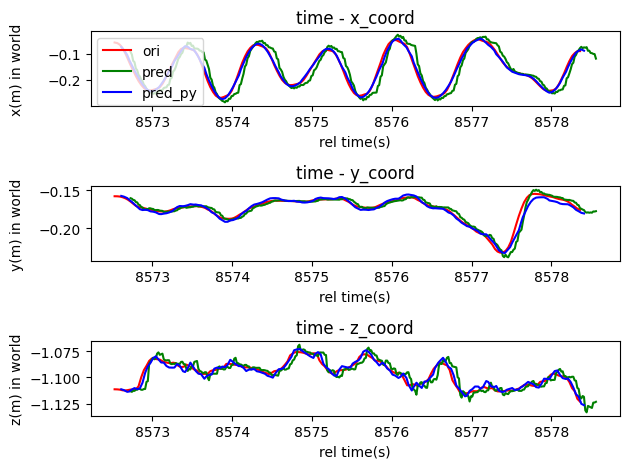

In [47]:
start_time_ori = int(len(file_list_ori)* 5/ 10)
end_time_ori = int(len(file_list_ori)*6/10)

start_time_pred = int(len(file_list_pred)* 5 / 10)
end_time_pred = int(len(file_list_pred)*6/10)


for index in range(1):  # keypoint index
    time_list_tmp_ori = []
    keypoints_tmp_ori = []

    time_list_tmp_pred_py = []
    keypoints_tmp_pred_py = []
    if test_left:
        raise NotImplementedError
    else:
        for i in range(start_time_ori, end_time_ori):
            if ori_info["is_tracked"]["right"][i]:
                time_list_tmp_ori.append(ori_info["timestamp"][i])
                keypoints_tmp_ori.append(ori_info["keypoints"]["right"][i][index])

                if i == start_time_ori:
                    last_mes = current_mes = ori_info["keypoints_filter"]["right"][i][index]
                    last_pre = current_pre = ori_info["keypoints_filter"]["right"][i][index]
                    current_xyz = current_pre
                    delta_xyz = current_xyz
                    delta_xyz_mmt = delta_xyz
                    # init kalman filter with t0 data
                    # kalman.statePre = np.zeros((6,1),dtype=np.float32)  
                    # kalman.statePre[0,0] = current_mes[0]               
                    # kalman.statePre[1,0] = current_mes[1]
                    # kalman.statePre[2,0] = current_mes[2]
                    # kalman.errorCovPre = np.zeros((6,6),dtype=np.float32)

                    kalman.statePost = np.zeros((6,1),dtype=np.float32)
                    kalman.statePost[0,0] = current_mes[0]
                    kalman.statePost[1,0] = current_mes[1]
                    kalman.statePost[2,0] = current_mes[2]
                    kalman.errorCovPost = np.zeros((6,6),dtype=np.float32)
                    
                else:
                    # last_pre = current_pre
                    # last_mes = current_mes
                    current_mes = ori_info["keypoints_filter"]["right"][i][index]  # （3，）
                    current_mes = current_mes[:,np.newaxis].astype(np.float32)
                    # print(f"current_mes:{current_mes}")

                    # print(f"step {i} state:-----------")

                    # print(f"kalman.statePre:{kalman.statePre.squeeze()}")
                    # print(f"kalman.statePost:{kalman.statePost.squeeze()}")
                    # print(f"kalman.errorCovPre:{kalman.errorCovPre}")
                    # print(f"kalman.errorCovPost:{kalman.errorCovPost}")
                    # print(f"kalman.gain:{kalman.gain}")

                    
                    # print("current_pre = kalman.predict()")
                    current_pre = kalman.predict()  # (6,1)  meanwhile asign errorCovPre to errorCovPost

                    # print(f"kalman.statePre:{kalman.statePre.squeeze()}")
                    # print(f"kalman.statePost:{kalman.statePost.squeeze()}")
                    # print(f"kalman.errorCovPre:{kalman.errorCovPre}")
                    # print(f"kalman.errorCovPost:{kalman.errorCovPost}")
                    # print(f"kalman.gain:{kalman.gain}")

                    
                    if i%1 == 0:
                    # if i - start_time_ori < 5:
                        # print("kalman.correct(current_mes)")
                        kalman.correct(current_mes)
                        # print(f"kalman.statePre:{kalman.statePre.squeeze()}")
                        # print(f"kalman.statePost:{kalman.statePost.squeeze()}")
                        # print(f"kalman.errorCovPre:{kalman.errorCovPre}")
                        # print(f"kalman.errorCovPost:{kalman.errorCovPost}")
                        # print(f"kalman.gain:{kalman.gain}")

                    current_stat = kalman.statePost
                    # current_stat = kalman.statePre
                    # print(f"current_stat:{current_stat}")

                    x,y,z,vx,vy,vz = current_stat.squeeze()
                    
                    current_xyz = np.array([x,y,z])
                    # print(f"current_xyz:{current_xyz}")

                    idx_tmp = ori_info["index"][i]
                    try:
                        delta_t = pred2play_dict[idx_tmp][0] / 1e9 / 2
                        # delta_t = 0.03333333
                    except:
                        delta_t = 0
                    delta_x = x + vx/0.0333333*delta_t
                    delta_y = y + vy/0.0333333*delta_t
                    delta_z = z + vz/0.0333333*delta_t
                    delta_xyz = np.array([delta_x, delta_y, delta_z])

                    #TODO: add one euro filter
                    
                    xyz_alpha = np.array([0.6, 0.8, 0.8])
                    delta_xyz = delta_xyz_mmt*xyz_alpha + delta_xyz*(1-xyz_alpha)
                    delta_xyz_mmt = delta_xyz
                
                    time_list_tmp_pred_py.append(ori_info["timestamp"][i]+delta_t)
                    # keypoints_tmp_pred_py.append(current_xyz)
                    keypoints_tmp_pred_py.append(delta_xyz)

                    

    time_list_tmp_pred = []
    keypoints_tmp_pred = []
    if test_left:
        for i in range(start_time_pred, end_time_pred):
            if pred_info["is_tracked"]["left"][i]:
                time_list_tmp_pred.append(pred_info["timestamp"][i])
                keypoints_tmp_pred.append(pred_info["keypoints"]["left"][i][index])
    else:
        for i in range(start_time_pred, end_time_pred):
            if pred_info["is_tracked"]["right"][i]:
                time_list_tmp_pred.append(pred_info["timestamp"][i])
                keypoints_tmp_pred.append(pred_info["keypoints"]["right"][i][index])

    keypoints_np_ori = np.array(keypoints_tmp_ori)
    keypoints_np_pred = np.array(keypoints_tmp_pred)
    keypoints_np_pred_py = np.array(keypoints_tmp_pred_py)

    fig = plt.figure()
    plt.subplot(3, 1, 1)
    plt.title("time - x_coord")
    plt.plot(time_list_tmp_ori, keypoints_np_ori[:, 0], "r", label='ori')
    plt.plot(time_list_tmp_pred, keypoints_np_pred[:, 0], "g", label='pred')
    plt.plot(time_list_tmp_pred_py, keypoints_np_pred_py[:, 0], "b", label='pred_py')
    plt.xlabel("rel time(s)")
    plt.ylabel("x(m) in world")
    plt.legend()

    plt.subplot(3, 1, 2)
    plt.title("time - y_coord")
    plt.plot(time_list_tmp_ori, keypoints_np_ori[:, 1], "r", label='ori')
    plt.plot(time_list_tmp_pred, keypoints_np_pred[:, 1], "g", label='pred')
    plt.plot(time_list_tmp_pred_py, keypoints_np_pred_py[:, 1], "b", label='pred_py')
    plt.xlabel("rel time(s)")
    plt.ylabel("y(m) in world")

    plt.subplot(3, 1, 3)
    plt.title("time - z_coord")
    plt.plot(time_list_tmp_ori, keypoints_np_ori[:, 2], "r", label='ori')
    plt.plot(time_list_tmp_pred, keypoints_np_pred[:, 2], "g", label='pred')
    plt.plot(time_list_tmp_pred_py, keypoints_np_pred_py[:, 2], "b", label='pred_py')
    plt.xlabel("rel time(s)")
    plt.ylabel("z(m) in world")

    fig.align_labels()
    plt.tight_layout()

    plt.savefig(f"{save_dir}/point_{index}.png")


## test accuracy

In [48]:
os.chdir(f"{save_dir}")

In [49]:
ori_eye = np.array([0,0,0,1])

## save as tum format to calculate slam error
ori_traj_eye = np.tile(ori_eye, keypoints_np_ori.shape[0]).reshape(-1, 4)
ori_traj = np.concatenate([np.array(time_list_tmp_ori)[:,np.newaxis], keypoints_np_ori,ori_traj_eye], axis=1)

pred_traj_eye = np.tile(ori_eye, keypoints_np_pred.shape[0]).reshape(-1, 4)
pred_traj = np.concatenate([np.array(time_list_tmp_pred)[:,np.newaxis], keypoints_np_pred, pred_traj_eye], axis=1)


pred_py_traj_eye = np.tile(ori_eye, keypoints_np_pred_py.shape[0]).reshape(-1, 4)
pred_py_traj = np.concatenate([np.array(time_list_tmp_pred_py)[:,np.newaxis], keypoints_np_pred_py,pred_py_traj_eye], axis=1)


In [50]:
np.savetxt(f"ori_traj.txt", ori_traj)
np.savetxt(f"pred_traj.txt", pred_traj)
np.savetxt(f"pred_py_traj.txt", pred_py_traj)

In [51]:
!evo_ape tum ori_traj.txt pred_py_traj.txt
!evo_ape tum ori_traj.txt pred_traj.txt

APE w.r.t. translation part (m)
(not aligned)

       max	0.032605
      mean	0.012184
    median	0.008870
       min	0.003159
      rmse	0.014441
       sse	0.006256
       std	0.007751

APE w.r.t. translation part (m)
(not aligned)

       max	0.089364
      mean	0.024937
    median	0.019741
       min	0.001951
      rmse	0.029697
       sse	0.149926
       std	0.016126

